In [0]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt 
import io
	
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
# Upload the data file
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [0]:
# Store the input data in a dataframe
df2 = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))

In [0]:
# Show the first few inputs
df2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
# Function to graph training history
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


In [0]:
# shuffle the dataframe so that the inputs are in a random order
df = df2.sample(frac=1).reset_index(drop=True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,86937.0,-1.283739,2.065273,-1.375477,-1.541884,1.078116,-1.237080,1.634169,-0.294756,0.376591,1.411456,0.755699,0.703337,0.058770,0.380774,-0.757728,-0.603150,-0.815837,-0.013140,0.053396,0.640266,0.078921,0.966021,-0.267667,-0.352384,-0.070779,0.060995,0.470108,0.046423,3.69,0
1,158251.0,0.033595,0.771641,0.103641,-0.808490,0.651276,-0.532775,0.880845,-0.007791,-0.210856,-0.231472,0.276824,0.451951,-0.397834,0.361386,-1.024291,0.261588,-0.809362,-0.047136,0.387252,-0.034809,-0.243913,-0.579826,0.007315,-0.510950,-0.468936,0.151648,0.239499,0.081615,5.16,0
2,129457.0,2.036388,-0.007515,-1.327342,0.334612,0.102665,-1.057305,0.224823,-0.326780,0.510703,-0.013637,-0.292398,0.557223,0.330463,0.440050,0.773418,-0.364487,-0.359470,-0.269621,-0.429691,-0.198024,0.276474,0.929102,0.076061,1.131801,0.232431,-0.163527,-0.020321,-0.046605,8.99,0
3,14474.0,1.256478,-0.090816,0.309819,-0.163729,0.125398,0.746019,-0.604981,0.134975,1.475953,-0.410868,1.447824,-1.723501,2.521045,1.499643,0.164728,0.759250,-0.206102,0.571585,0.036018,-0.019607,-0.069627,0.095122,-0.173814,-1.308666,0.305465,1.125860,-0.074595,-0.020295,15.95,0
4,166729.0,-0.205879,1.196233,-0.979493,-0.071517,0.520330,-1.393490,0.656765,0.051039,-0.226087,-1.113709,-0.706116,0.026867,0.419952,-0.722382,0.638277,0.220689,0.596904,0.776139,-0.137404,-0.243677,0.339017,1.004393,-0.032166,-0.176571,-0.289230,-0.154496,-0.111707,0.020902,9.67,0


In [0]:
# Scale the time and amount columns, since the rest of the features are scaled
robust_scaler = RobustScaler()

df['scaled_amount'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [0]:
# Scaled amount and time
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# Insert into beginning of df
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Show the result
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.255851,0.026375,-1.283739,2.065273,-1.375477,-1.541884,1.078116,-1.237080,1.634169,-0.294756,0.376591,1.411456,0.755699,0.703337,0.058770,0.380774,-0.757728,-0.603150,-0.815837,-0.013140,0.053396,0.640266,0.078921,0.966021,-0.267667,-0.352384,-0.070779,0.060995,0.470108,0.046423,0
1,-0.235311,0.864190,0.033595,0.771641,0.103641,-0.808490,0.651276,-0.532775,0.880845,-0.007791,-0.210856,-0.231472,0.276824,0.451951,-0.397834,0.361386,-1.024291,0.261588,-0.809362,-0.047136,0.387252,-0.034809,-0.243913,-0.579826,0.007315,-0.510950,-0.468936,0.151648,0.239499,0.081615,0
2,-0.181793,0.525911,2.036388,-0.007515,-1.327342,0.334612,0.102665,-1.057305,0.224823,-0.326780,0.510703,-0.013637,-0.292398,0.557223,0.330463,0.440050,0.773418,-0.364487,-0.359470,-0.269621,-0.429691,-0.198024,0.276474,0.929102,0.076061,1.131801,0.232431,-0.163527,-0.020321,-0.046605,0
3,-0.084539,-0.824939,1.256478,-0.090816,0.309819,-0.163729,0.125398,0.746019,-0.604981,0.134975,1.475953,-0.410868,1.447824,-1.723501,2.521045,1.499643,0.164728,0.759250,-0.206102,0.571585,0.036018,-0.019607,-0.069627,0.095122,-0.173814,-1.308666,0.305465,1.125860,-0.074595,-0.020295,0
4,-0.172291,0.963792,-0.205879,1.196233,-0.979493,-0.071517,0.520330,-1.393490,0.656765,0.051039,-0.226087,-1.113709,-0.706116,0.026867,0.419952,-0.722382,0.638277,0.220689,0.596904,0.776139,-0.137404,-0.243677,0.339017,1.004393,-0.032166,-0.176571,-0.289230,-0.154496,-0.111707,0.020902,0


In [0]:
# Split the data into training (80%) and testing (20%)
train, test = train_test_split(df, test_size=0.2)

In [0]:
# Upsample fraud data
'''df_genuine = train[train.Class==0]
df_fraud = train[train.Class==1]

df_fraud_upsampled = resample(df_fraud, 
                                 replace=True,     
                                 n_samples=40000,    
                                 random_state=123) 

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_genuine, df_fraud_upsampled])
 
# Display new class counts
df_upsampled.Class.value_counts()

0    227459
1     40000
Name: Class, dtype: int64

In [0]:
# Split data into features and labels
train_features = np.array(train.values[:,0:30])
train_labels = np.array(train.values[:,-1])
test_features = np.array(test.values[:,0:30])
test_labels = np.array(test.values[:,-1])

In [0]:
print(train_features.shape)
print(test_features.shape)

(227845, 30)
(56962, 30)


In [0]:
# Neural network model - may play around with number of layers and nodes a bit more
model = Sequential()
model.add(Dense(units=100, 
                input_dim=30, 
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=100,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,
                kernel_initializer='uniform',
                activation='sigmoid'))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               3100      
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 13,301
Trainable params: 13,301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Train the model
train_history = model.fit(x=train_features, y=train_labels,
                          validation_split=0.8, epochs=100, 
                          batch_size=512, verbose=1)

Train on 45568 samples, validate on 182277 samples
Epoch 1/100
45568/45568 [==============================] - 2s 36us/step - loss: 0.2327 - acc: 0.9835 - val_loss: 0.0080 - val_acc: 0.9983
Epoch 2/100
45568/45568 [==============================] - 1s 23us/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.0053 - val_acc: 0.9983
Epoch 3/100
45568/45568 [==============================] - 1s 23us/step - loss: 0.0042 - acc: 0.9982 - val_loss: 0.0049 - val_acc: 0.9983
Epoch 4/100
45568/45568 [==============================] - 1s 23us/step - loss: 0.0037 - acc: 0.9982 - val_loss: 0.0047 - val_acc: 0.9983
Epoch 5/100
45568/45568 [==============================] - 1s 23us/step - loss: 0.0031 - acc: 0.9982 - val_loss: 0.0047 - val_acc: 0.9983
Epoch 6/100
45568/45568 [==============================] - 1s 23us/step - loss: 0.0029 - acc: 0.9982 - val_loss: 0.0047 - val_acc: 0.9983
Epoch 7/100
45568/45568 [==============================] - 1s 23us/step - loss: 0.0027 - acc: 0.9982 - val_loss: 0.0047 -

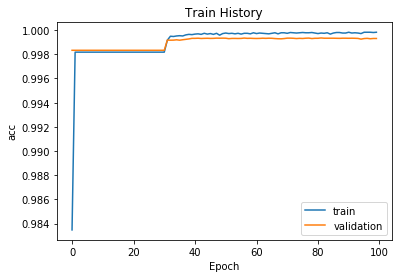

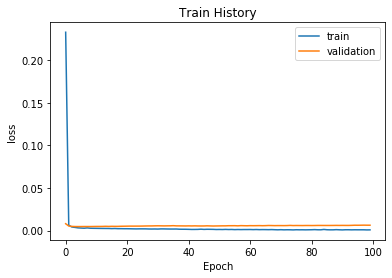

In [0]:
# Show graphs of training history for accuracy and loss
show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')

In [0]:
# Get model accuracy 
scores = model.evaluate(test_features, test_labels)
print('\n')
print('accuracy=',scores[1])

56962/56962 [==============================] - 1s 23us/step


accuracy= 0.999385555282469


In [0]:
# Get predictions from model
output = model.predict_classes(test_features)

In [0]:
# Show confusion matrix
y_actu = pd.Series(test_labels, name='Actual')
y_pred = pd.Series(np.ndarray.flatten(output), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

Predicted      0   1
Actual              
0.0        56847  10
1.0           25  80
